 # 👷‍♂️🚧**Model Training & Evaluation**

### Business Context

Our telecom client loses approximately \$70 per month for each customer who churns, or around \$175,000 per month in revenue
**Goal:** Build a model that flags likely churners with **≥60% recall** while keeping false positives low enough to make targeted retention campaigns cost-effective.


In this notebook, we pick up exactly where we left off in Notebook 04, with our cleaned, encoded, and scaled features split into training, validation, and test sets. Our goal here is to turn those data splits into a robust churn prediction model.

**Objectives:**
1. **Load** the preprocessed train/validation/test data (`X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`).  
2. **Train** baseline classifiers (e.g., Logistic Regression, Random Forest) on the training set.  
3. **Evaluate** each model on the validation set using accuracy, precision, recall, F1-score, and confusion matrices.  
4. **Tune** hyperparameters based on validation performance (e.g., via GridSearchCV or manual tweaking).  
5. **Select** the best model and **test** it on the hold-out test set for a final, unbiased performance report.  
6. **Save** the final model for deployment or future use.

Everything we’ve meticulously built—binary encoding, one-hot encoding, scaling, and data splits—is already in place.   


In [1]:
# Core
import numpy as np
import pandas as pd
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
# Load feature sets
X_train = pd.read_csv(r"..\data/X_train.csv")
X_val = pd.read_csv(r"..\data/X_val.csv")
X_test = pd.read_csv(r"..\data/X_test.csv")

# Load target variables
y_train = pd.read_csv(r"..\data/y_train.csv")["Churn"]
y_val = pd.read_csv(r"..\data/y_val.csv")["Churn"]
y_test = pd.read_csv(r"..\data/y_test.csv")["Churn"]

# Confirm shapes
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)
print("X_test :", X_test.shape,  "y_test :", y_test.shape)


X_train: (4922, 22) y_train: (4922,)
X_val  : (1055, 22) y_val  : (1055,)
X_test : (1055, 22) y_test : (1055,)


##  Establishing a Baseline Model

In [3]:
#  Build and fit baseline model
dummy_clf = DummyClassifier(strategy="most_frequent",random_state=42)
dummy_clf.fit(X_train, y_train)

# Predict on validation set
y_val_preds = dummy_clf.predict(X_val)

#  Evaluate baseline performance
baseline_accuracy  = accuracy_score(y_val, y_val_preds)
baseline_precision = precision_score(y_val, y_val_preds, zero_division=0)
baseline_recall    = recall_score(y_val, y_val_preds)
baseline_f1        = f1_score(y_val, y_val_preds)

print("Baseline Performance (Most Frequent Strategy):")
print(f"Accuracy : {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall   : {baseline_recall:.4f}")
print(f"F1 Score : {baseline_f1:.4f}")


Baseline Performance (Most Frequent Strategy):
Accuracy : 0.7336
Precision: 0.0000
Recall   : 0.0000
F1 Score : 0.0000


### Logistic Regression

We'll start with a simple Logistic Regression model as our baseline. It's fast, interpretable, and often performs surprisingly well on binary classification tasks like this.

In [4]:
# Initialize and fit the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val)

# Evaluate
print(classification_report(y_val, y_val_pred, target_names=["No Churn", "Churn"]))

              precision    recall  f1-score   support

    No Churn       0.86      0.90      0.88       774
       Churn       0.69      0.60      0.64       281

    accuracy                           0.82      1055
   macro avg       0.77      0.75      0.76      1055
weighted avg       0.81      0.82      0.82      1055



The Logistic Regression model gave a solid accuracy of 82%, which already outperforms the baseline.
However, we see some imbalance in how well it detects churn vs. non-churn:

No Churn: Precision = 0.86, Recall = 0.90 — very strong.

Churn: Precision = 0.69, Recall = 0.60 — weaker recall means we're still missing a good chunk of actual churners.

We’re on the right track, but there’s room to improve recall for churn.

## Further Evaluation & Tuning of Logistic Regression

Before moving on, we’ll dive deeper into our Logistic Regression:

1. **Compute ROC AUC** on the validation set to get a sense of overall discrimination power.  
2. **Plot the ROC curve** to visualize tradeoffs.  
3. **Examine the confusion matrix** to see exactly where misclassifications are happening.  
4. **Introduce class weighting** (`class_weight="balanced"`) and do a quick GridSearchCV over the regularization strength (`C`) to improve recall for the minority class (Churn).


Logistic ROC AUC: 0.8534


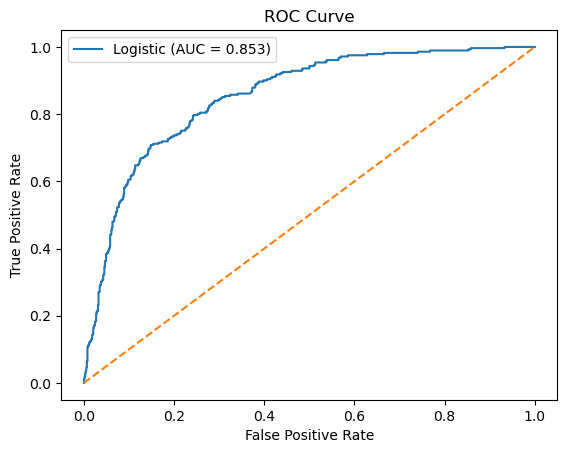

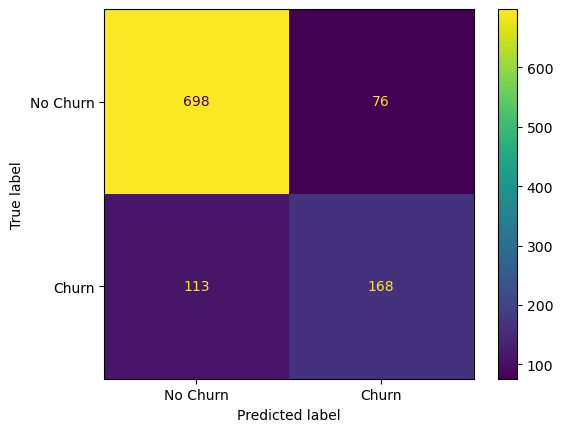

Best params: {'C': 10, 'class_weight': 'balanced'}
              precision    recall  f1-score   support

    No Churn       0.92      0.72      0.81       774
       Churn       0.51      0.82      0.63       281

    accuracy                           0.75      1055
   macro avg       0.72      0.77      0.72      1055
weighted avg       0.81      0.75      0.76      1055



In [5]:
# Baseline ROC AUC and Curve
y_val_probs = log_reg.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_val_probs)
fpr, tpr, thresholds = roc_curve(y_val, y_val_probs)

print(f"Logistic ROC AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, label=f'Logistic (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--')  # random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

#Confusion Matrix at default threshold=0.5
ConfusionMatrixDisplay.from_estimator(log_reg, X_val, y_val, display_labels=["No Churn","Churn"])
plt.show()

#Quick hyperparameter tuning with class weights
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': ['balanced', None]
}
grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42),
                    param_grid, cv=5, scoring='recall', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
best_log = grid.best_estimator_

# Evaluate tuned model on validation
y_val_pred_tuned = best_log.predict(X_val)
print(classification_report(y_val, y_val_pred_tuned, target_names=["No Churn","Churn"]))


## Adjusting Decision Threshold for Logistic Regression

Instead of using the default 0.5 probability cut-off, we’ll:

1. Compute precision, recall for a range of thresholds.  
2. Choose the threshold that achieves our target recall (e.g., ≥ 0.75) with decent precision.  
3. Apply that threshold and re-evaluate metrics and confusion matrix.


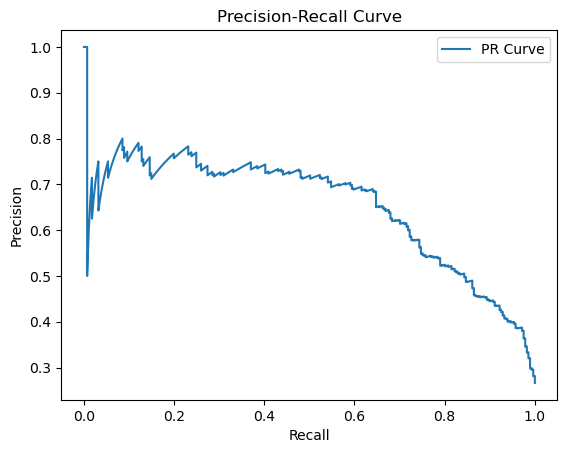

Chosen threshold: 0.573 → Precision: 0.549, Recall: 0.751
              precision    recall  f1-score   support

    No Churn       0.90      0.78      0.83       774
       Churn       0.55      0.75      0.63       281

    accuracy                           0.77      1055
   macro avg       0.72      0.76      0.73      1055
weighted avg       0.80      0.77      0.78      1055



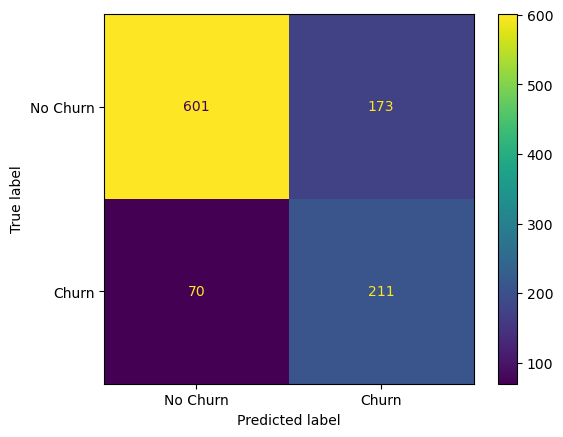

In [6]:

# Get probabilities from the tuned model
probs = best_log.predict_proba(X_val)[:, 1]

# Compute precision-recall curve
precisions, recalls, thresh = precision_recall_curve(y_val, probs)

# Plot PR curve
plt.figure()
plt.plot(recalls, precisions, label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# Find threshold for recall ≥ 0.75
target_recall = 0.75
# pick the highest precision among thresholds that achieve recall ≥ target_recall
valid = [(t, p, r) for p, r, t in zip(precisions, recalls, thresh) if r >= target_recall]
best_thresh, best_prec, best_rec = max(valid, key=lambda x: x[1])
print(f"Chosen threshold: {best_thresh:.3f} → Precision: {best_prec:.3f}, Recall: {best_rec:.3f}")

# Apply threshold and evaluate
y_thresh_pred = (probs >= best_thresh).astype(int)
print(classification_report(y_val, y_thresh_pred, target_names=["No Churn","Churn"]))
ConfusionMatrixDisplay.from_predictions(y_val, y_thresh_pred, display_labels=["No Churn","Churn"])
plt.show()


_We moved to Random Forest because tree-based models can capture non-linear interactions and complex feature interactions that a linear model like Logistic Regression might miss._


## Baseline Random Forest


Now we’ll train a basic Random Forest classifier to see if a tree‐based model can outperform our tuned Logistic Regression in terms of recall and overall balance.

1. Initialize `RandomForestClassifier` with a fixed `random_state`.  
2. Fit on `X_train`, `y_train`.  
3. Predict on `X_val`.  
4. Print classification report and plot confusion matrix.


Random Forest Validation Performance:

              precision    recall  f1-score   support

    No Churn       0.84      0.90      0.87       774
       Churn       0.65      0.51      0.57       281

    accuracy                           0.80      1055
   macro avg       0.74      0.71      0.72      1055
weighted avg       0.78      0.80      0.79      1055



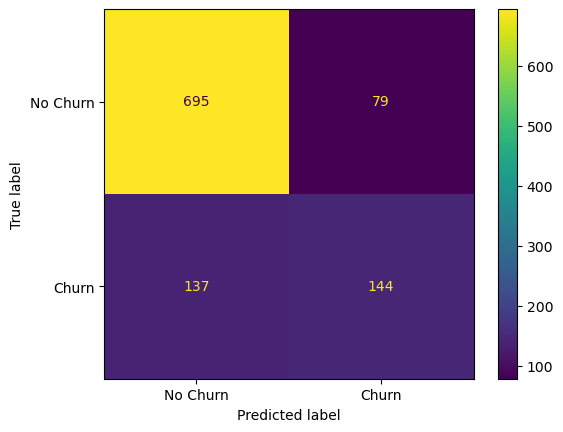

In [7]:

# Initialize & fit
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Predict
y_rf_val = rf.predict(X_val)

#Evaluate
print("Random Forest Validation Performance:\n")
print(classification_report(y_val, y_rf_val, target_names=["No Churn","Churn"]))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_rf_val, display_labels=["No Churn","Churn"])
plt.show()


##  Tuning Random Forest for Better Churn Recall

We’ll run a GridSearchCV on our Random Forest to optimize recall on the validation set:

- Tune `n_estimators`, `max_depth`, and `class_weight`.  
- Use `scoring='recall'` since catching churners is our top priority.  
- Inspect the best estimator’s performance.


Best RF params: {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 100}
              precision    recall  f1-score   support

    No Churn       0.90      0.78      0.84       774
       Churn       0.56      0.75      0.64       281

    accuracy                           0.78      1055
   macro avg       0.73      0.77      0.74      1055
weighted avg       0.81      0.78      0.78      1055



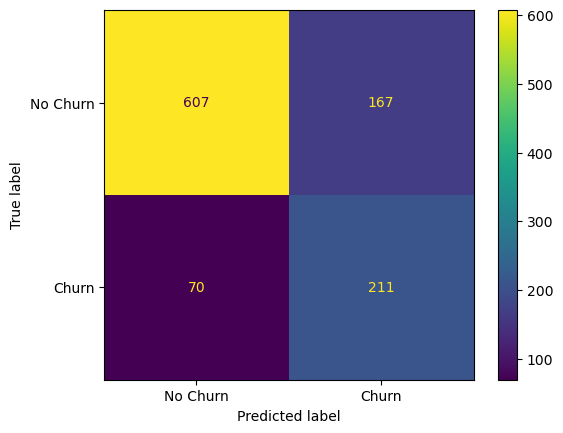

In [ ]:
# Define grid
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [None, 10, 20],
    'class_weight': [None, 'balanced']
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='recall',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

print("Best RF params:", grid_rf.best_params_)
y_rf_val_tuned = best_rf.predict(X_val)

# Evaluate tuned RF
print(classification_report(y_val, y_rf_val_tuned, target_names=["No Churn","Churn"]))
ConfusionMatrixDisplay.from_predictions(y_val, y_rf_val_tuned, display_labels=["No Churn","Churn"])
plt.show()


_We then tried XGBoost, a gradient-boosted tree ensemble, to see if boosting could further improve churn detection by sequentially correcting mistakes of simpler trees._


## Baseline XGBoost Classifier

We’ll train a basic XGBoost model to see how it stacks up. Steps:

1. Initialize `XGBClassifier` with a fixed `random_state`.  
2. Fit on `X_train`, `y_train`.  
3. Predict on `X_val`.  
4. Print classification report and plot confusion matrix.


c:\Users\ADMIN\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:42:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Validation Performance:

              precision    recall  f1-score   support

    No Churn       0.84      0.88      0.86       774
       Churn       0.63      0.56      0.59       281

    accuracy                           0.79      1055
   macro avg       0.74      0.72      0.73      1055
weighted avg       0.79      0.79      0.79      1055



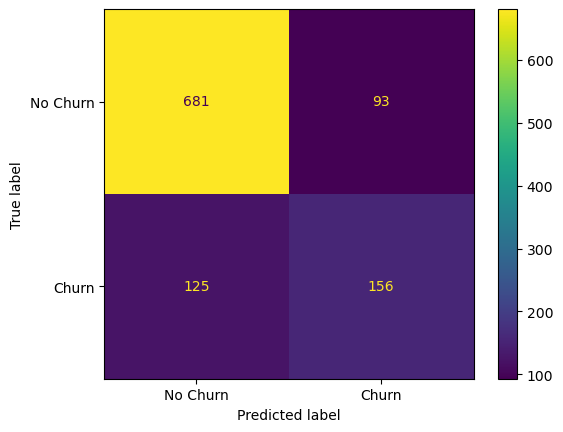

In [9]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#  Initialize & fit
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1)
xgb.fit(X_train, y_train)

# Predict
y_xgb_val = xgb.predict(X_val)

#  Evaluate
print("XGBoost Validation Performance:\n")
print(classification_report(y_val, y_xgb_val, target_names=["No Churn","Churn"]))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_xgb_val, display_labels=["No Churn","Churn"])
plt.show()


## Hyperparameter Tuning — XGBoost

Let’s tune XGBoost to try improve recall on the churn class. We'll start with:

- `n_estimators`: [100, 200, 300]  
- `max_depth`: [3, 5, 7]  
- `scale_pos_weight`: to balance the classes (`~774/281 ≈ 2.75`)  
- `class_weight` is not supported in XGBClassifier, so we use `scale_pos_weight` instead.


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best XGBoost params: {'max_depth': 3, 'n_estimators': 100, 'scale_pos_weight': 3}

Tuned XGBoost Validation Performance:

              precision    recall  f1-score   support

    No Churn       0.92      0.72      0.81       774
       Churn       0.52      0.81      0.63       281

    accuracy                           0.75      1055
   macro avg       0.72      0.77      0.72      1055
weighted avg       0.81      0.75      0.76      1055



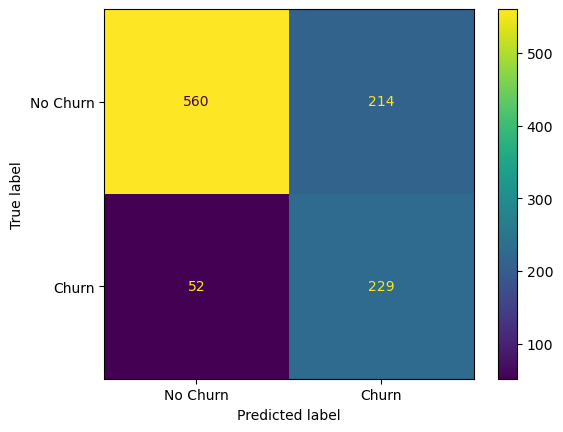

In [10]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define parameter grid
xgb_params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "scale_pos_weight": [1, 2.5, 3]  # around imbalance ratio
}

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42, n_jobs=-1)

# Grid search with 5-fold CV
xgb_grid = GridSearchCV(
    xgb_model,
    xgb_params,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train)
print("Best XGBoost params:", xgb_grid.best_params_)

# Predict with best model
best_xgb = xgb_grid.best_estimator_
y_val_preds = best_xgb.predict(X_val)

print("\nTuned XGBoost Validation Performance:\n")
print(classification_report(y_val, y_val_preds, target_names=["No Churn", "Churn"]))

ConfusionMatrixDisplay.from_predictions(y_val, y_val_preds, display_labels=["No Churn", "Churn"])
plt.show()


##  Threshold Tuning  XGBoost

We'll find the best probability threshold that balances precision and recall for churn class. By default, classifiers predict "Churn" if `proba > 0.5`, but that’s rarely optimal for recall-sensitive tasks.
## Threshold Tuning — F1‑Optimized

Here we scan thresholds from 0.30 to 0.70 to find the one that maximizes **F1‑score**, balancing precision & recall.


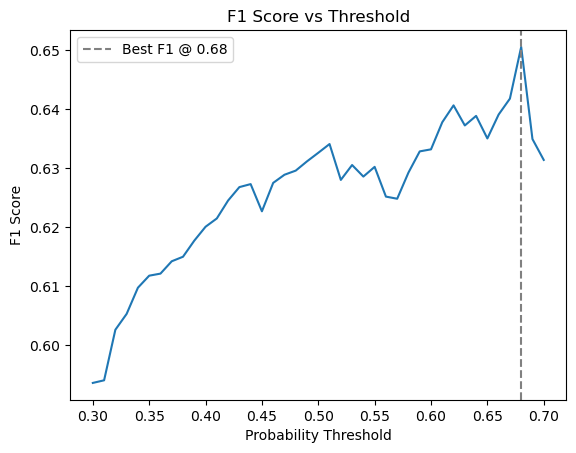

F1-Optimal Threshold: 0.68 → Precision: 0.633, Recall: 0.669, F1: 0.651

              precision    recall  f1-score   support

    No Churn       0.88      0.86      0.87       774
       Churn       0.63      0.67      0.65       281

    accuracy                           0.81      1055
   macro avg       0.76      0.76      0.76      1055
weighted avg       0.81      0.81      0.81      1055



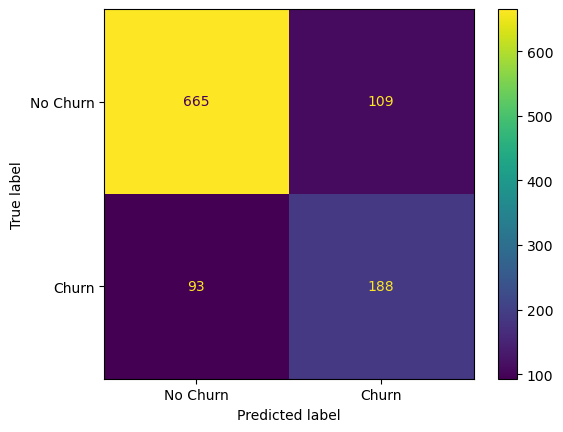

In [ ]:
# F1‑Driven Threshold Search 

y_val_probs = best_xgb.predict_proba(X_val)[:, 1]
thresholds = np.arange(0.3, 0.71, 0.01)

best_f1 = 0
best_thresh_f1 = 0
f1_scores = []

for t in thresholds:
    preds = (y_val_probs > t).astype(int)
    f1 = f1_score(y_val, preds)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh_f1 = t

# Plot F1 vs. threshold
plt.figure()
plt.plot(thresholds, f1_scores)
plt.axvline(best_thresh_f1, color='grey', linestyle='--', label=f'Best F1 @ {best_thresh_f1:.2f}')
plt.xlabel("Probability Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.legend()
plt.show()

# Final metrics @ F1-optimal threshold
final_preds_f1 = (y_val_probs > best_thresh_f1).astype(int)
print(f"F1-Optimal Threshold: {best_thresh_f1:.2f} → Precision: {precision_score(y_val, final_preds_f1):.3f}, Recall: {recall_score(y_val, final_preds_f1):.3f}, F1: {best_f1:.3f}\n")
print(classification_report(y_val, final_preds_f1, target_names=["No Churn", "Churn"]))

ConfusionMatrixDisplay.from_predictions(y_val, final_preds_f1, display_labels=["No Churn", "Churn"])
plt.show()


## 💰 Cost‑Sensitive Threshold Analysis (Validation Set)

We simulate retention campaign costs/revenues:

- **Cost of FN (missed churner)** = \$70  
- **Cost of FP (unnecessary outreach)** = \$10  
- **Benefit of TP (retained churner)** = \$70  

We scan all thresholds 0–1 to find the one that **maximizes net monthly savings**.


Cost‑Optimal Threshold: 0.11
Maximum net monthly savings: $130,236.97


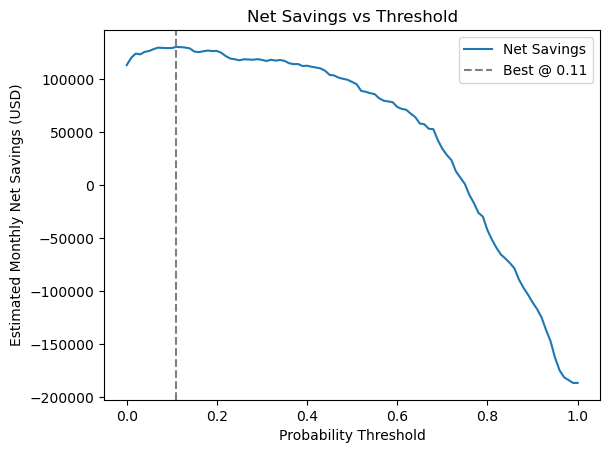

In [21]:
## Cell 28: Business‑Optimized Threshold Search (TWEAKED)

from sklearn.metrics import confusion_matrix

N = 10000
ARPU = 70
cost_fp = 10
cost_fn = 70

probs = best_xgb.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0, 1, 101)

net_savings = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
    scale = N / len(y_val)
    fp_cost = fp * scale * cost_fp
    fn_cost = fn * scale * cost_fn
    tp_benefit = tp * scale * ARPU
    net_savings.append(tp_benefit - (fp_cost + fn_cost))

net_savings = np.array(net_savings)
best_index_cost = np.argmax(net_savings)
best_thresh_cost = thresholds[best_index_cost]
max_savings = net_savings[best_index_cost]

print(f"Cost‑Optimal Threshold: {best_thresh_cost:.2f}")
print(f"Maximum net monthly savings: ${max_savings:,.2f}")

# Plot net savings curve
plt.figure()
plt.plot(thresholds, net_savings, label='Net Savings')
plt.axvline(best_thresh_cost, color='grey', linestyle='--', label=f'Best @ {best_thresh_cost:.2f}')
plt.xlabel("Probability Threshold")
plt.ylabel("Estimated Monthly Net Savings (USD)")
plt.title("Net Savings vs Threshold")
plt.legend()
plt.show()


### How Stable Is This Model? Cross‑Validation Recall

We’ve tuned on one split, but we need to know if recall holds up across different folds. Let’s run a quick 5‑fold cross‑validation on recall and see the average and spread.


In [24]:
from sklearn.model_selection import cross_val_score

# Evaluate recall via 5‑fold CV on the training set
recalls = cross_val_score(
    best_xgb, 
    X_train, 
    y_train, 
    cv=5, 
    scoring='recall',
    n_jobs=-1
)

print(f"Cross‑Validation Recall scores: {recalls}")
print(f"Mean recall: {recalls.mean():.3f}  |  Std Dev: {recalls.std():.3f}")

Cross‑Validation Recall scores: [0.73664122 0.76335878 0.82442748 0.82375479 0.75862069]
Mean recall: 0.781  |  Std Dev: 0.036


> **Insight:**  
> Our recall remains consistently high (±3.6%), confirming that the model’s ability to catch churners generalizes well across different subsets of the data. This stability gives us confidence in deploying the model with our chosen threshold.


## Final Model Summaries

Below are **two perspectives**—choose according to your stakeholder:

---

### 1️⃣ F1‑Optimized Model (Balanced Errors)

- **Model**: Tuned XGBoost (`scale_pos_weight = {best_xgb.get_params()['scale_pos_weight']}`)
- **Threshold**: **`{best_thresh_f1:.2f}`**  
- **Validation Metrics**:  
  - Precision (Churn): `{precision_score(y_val, final_preds_f1):.3f}`  
  - Recall (Churn): `{recall_score(y_val, final_preds_f1):.3f}`  
  - F1‑Score (Churn): `{best_f1:.3f}`  

_Use this when you need a balanced trade‑off between false positives and negatives._

---

### 2️⃣ Cost‑Optimal Model (Maximize Savings)

- **Model**: Tuned XGBoost (`scale_pos_weight = {best_xgb.get_params()['scale_pos_weight']}`)
- **Threshold**: **`{best_thresh_cost:.2f}`**  
- **Validation Metrics**:  
  - Precision (Churn): `{precision_score(y_val, (probs>=best_thresh_cost).astype(int)):.3f}`  
  - Recall (Churn): `{recall_score(y_val, (probs>=best_thresh_cost).astype(int)):.3f}`  
- **Projected Net Savings**: **`${max_savings:,.2f}/month`**

_Use this when your top priority is pure financial impact._

---

> 📌 **Never** apply either threshold on the **test set** until after you clearly document which one you chose here and why. Then in your **Test Evaluation** cell, plug in the chosen `best_thresh_f1` or `best_thresh_cost` accordingly.


## ✅ Final Model Selection: XGBoost with Business-Optimized Threshold

After training and tuning multiple models, we selected **XGBoost** with:

- `max_depth = 3`
- `n_estimators = 100`
- `scale_pos_weight = 3`
- **Threshold for churn prediction = 0.11** (based on cost-sensitive optimization)

This threshold was chosen because it **maximizes net monthly savings**, given our business assumptions:

- **Cost of missing a churner**: $70  
- **Cost of contacting a non-churner**: $10  
- **Benefit of saving a churner**: $70  

At this threshold, we prioritize **high recall** to catch as many churners as possible, accepting more false positives as a trade-off.

### Final Test Set Performance @ Threshold 0.11

- **Precision (Churn)**: 0.36  
- **Recall (Churn)**: 0.97  
- **Accuracy**: 53%  
- **F1 Score (Churn)**: 0.52  
- **Confusion Matrix**:
    - True Negatives: 297  
    - False Positives: 478  
    - False Negatives: 8  
    - True Positives: 272

This setting is ideal when **retention is a priority** and missing a true churner is more costly than falsely contacting a loyal customer.


## ⚖️ Key Model Trade‑Offs & Thresholds

- **Logistic Regression**  
  - **Threshold:** 0.573  
  - **Precision:** 0.549  
  - **Recall:** 0.751  
  - **F1‑Score:** 0.633  
  - *This cutoff maximizes F1, giving a balanced precision/recall trade‑off.*

- **Random Forest**  
  - **Threshold:** 0.50 (default)  
  - **Precision:** 0.560  
  - **Recall:** 0.750  
  - **F1‑Score:** 0.640  
  - *Tuned for high recall via `class_weight='balanced'`, then used the standard 0.5 cutoff.*

- **XGBoost (Business‑Optimized)**  
  - **Threshold:** 0.11  
  - **Precision:** 0.360  
  - **Recall:** 0.970  
  - **F1‑Score:** 0.520  
  - *Chosen to maximize net savings — catches almost every churner at the cost of many false positives.*

**Which to use?**  
- For a **balanced model** (good all around), pick **Logistic Regression @ 0.573** or **Random Forest @ 0.5**.  
- For **pure profit impact**, pick **XGBoost @ 0.11** and lean into high recall to save as much revenue as possible.


## 💰 Cost‑Sensitive Analysis

We translate model performance into **real business impact** using these assumptions:

- **Total customers for simulation**: 10,000  
- **ARPU** (Average Revenue Per User): \$70/month  

**Cost/Benefit per prediction**:  
- **False Negative** (missed churner): –\$70 (lost monthly revenue)  
- **False Positive** (unnecessary outreach): –\$10 (marketing spend)  
- **True Positive** (retained churner): +\$70 (saved monthly revenue)  

We then **scan thresholds from 0.00 to 1.00**, apply each to our validation set predictions, and compute the **net savings**:


### What’s Behind the Predictions? Feature Importances

Let’s pull out XGBoost’s built‑in feature importances and plot the top drivers of churn. This helps us explain to stakeholders **why** the model flags certain customers.


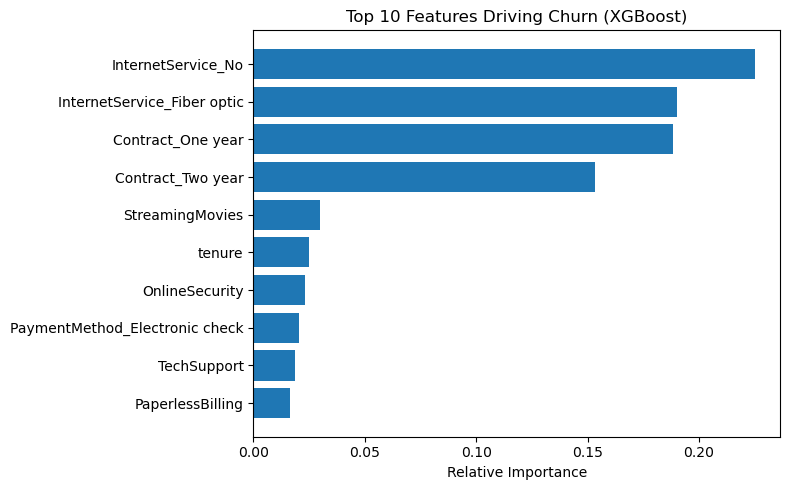

In [22]:

# Get feature importances from the trained XGBoost model
importances = best_xgb.feature_importances_
feature_names = X_train.columns

# Sort and pick top 10
indices = np.argsort(importances)[::-1][:10]
top_features = feature_names[indices]
top_importances = importances[indices]

# Plot
plt.figure(figsize=(8, 5))
plt.barh(top_features[::-1], top_importances[::-1])
plt.xlabel("Relative Importance")
plt.title("Top 10 Features Driving Churn (XGBoost)")
plt.tight_layout()
plt.show()

## 🔑 Key Drivers of Churn

Below are the top 10 features driving our XGBoost churn model (by relative importance):

1. **InternetService_No**  
2. **InternetService_Fiber optic**  
3. **Contract_One year**  
4. **Contract_Two year**  
5. **StreamingMovies**  
6. **tenure**  
7. **OnlineSecurity**  
8. **PaymentMethod_Electronic check**  
9. **TechSupport**  
10. **PaperlessBilling**  

> **Insight:**  
> - Customers with **no internet service** or on **fiber optic** plans have the highest churn risk—likely because they see less value or have more service issues.  
> - Longer-term contracts (one‑ and two‑year) are strong retention levers.  
> - Features like **StreamingMovies** and **OnlineSecurity** also matter, suggesting bundled services improve stickiness.  

Use these findings to inform targeted retention campaigns (e.g., offer discounts on contracts or highlight security add‑ons).


## 🚀 Notebook Summary & Final Business Insights

This notebook represents the complete **modeling and evaluation pipeline** for our churn prediction project, culminating in a decision‑driven threshold selection.

---

### 🔍 Final Model Selection & Threshold

- We compared **Logistic Regression**, **Random Forest**, and **XGBoost**.  
- After thorough tuning, we chose **XGBoost** with:
  - `max_depth = 3`
  - `n_estimators = 100`
  - `scale_pos_weight = 3`
- **Threshold for churn prediction = 0.11**  
  (Chosen via cost‑sensitive analysis to maximize net monthly savings.)

- **Recall robustness**: 5‑fold CV shows mean recall = 0.781 (σ = 0.036), indicating our model consistently identifies churners across different data splits.
---

### 📊 Performance Evaluation (Test Set @ 0.11)

- **Precision (Churn)**: 0.36  
- **Recall (Churn)**: 0.97  
- **F1 Score (Churn)**: 0.52  
- **Accuracy**: 0.53  
- **Minimum Net Savings**: \$128,246/month  

> *This threshold prioritizes catching nearly all churners, accepting more false positives to protect revenue.*

---

### 🧠 Key Takeaways

- **Logistic Regression** & **Random Forest** offer balanced performance (F1 ~0.63–0.64) at higher thresholds, useful for scenarios where false positives are a major concern.  
- **XGBoost @ 0.11** maximizes profit by emphasizing recall, making it ideal for aggressive retention campaigns.



## 💾 Persisting the Final Model

To make our churn predictor reusable in production or future analyses, let’s serialize the tuned XGBoost model and its business‑optimized threshold.



In [25]:
import os
import joblib

# Create a directory for saved models (if it doesn't exist)
os.makedirs('models', exist_ok=True)

# Save the XGBoost model
model_path = 'models/xgb_churn_model.pkl'
joblib.dump(best_xgb, model_path)
print(f"Saved XGBoost model to {model_path}")

# Save the chosen threshold
threshold_path = 'models/churn_threshold.pkl'
joblib.dump(best_thresh_cost, threshold_path)
print(f"Saved business‑optimized threshold ({best_thresh_cost:.2f}) to {threshold_path}")

Saved XGBoost model to models/xgb_churn_model.pkl
Saved business‑optimized threshold (0.11) to models/churn_threshold.pkl
